<a href="https://colab.research.google.com/github/1oneweeek/TIL/blob/main/classification4_torch_%EC%A4%91%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0. 라이브러리

In [ ]:
# python=3.8
# conda install ipykernel jupyter
import nltk
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaForSequenceClassification, RobertaTokenizer, AdamW
from torch.utils.data import DataLoader, Dataset
import torch
import matplotlib.pyplot as plt

### 1. 데이터 불러오기

In [ ]:
# pip install xlrd>=2.0.1
file_path = "/home/jinmin/FOOD/식품안전정보DB-url 추가(2014~2023).xls"  # 파일 경로
df = pd.read_excel(file_path, sheet_name= "2023", usecols=[3, 4, 8])  # 제목, 내용, 원인요소 칼럼 추출

In [ ]:
df.info()  # 20,775개

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20775 entries, 0 to 20774
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제목      20775 non-null  object
 1   내용      20775 non-null  object
 2   원인요소    20775 non-null  object
dtypes: object(3)
memory usage: 487.0+ KB


In [ ]:
df[25:100]

,제목,내용,원인요소
25,"중국 후난성 시장감독관리국, 메탄올 기준 초과로 주류 부적합","후난(湖南)성 시장감독관리국, 2023년 제43기 부적합 식품 공고 - 생산기업: ...",안전위생>위생>위생
26,"중국 후난성 시장감독관리국, 소브산 기준 초과로 식육가공품 부적합","후난(湖南)성 시장감독관리국, 2023년 제43기 부적합 식품 공고 - 생산기업: ...",화학적 위해요소>식품첨가물>소르빈산
27,"중국 후난성 시장감독관리국, 세균수 기준 초과로 농산가공식품류 부적합","후난(湖南)성 시장감독관리국, 2023년 제42기 부적합 식품 공고 - 생산기업: ...",생물학적 위해요소>미생물>세균수
28,"중국 후난성 시장감독관리국, 사이클라민산나트륨 사용기준 위반으로 주류 부적합","후난(湖南)성 시장감독관리국, 2023년 제42기 부적합 식품 공고 - 생산기업: ...",화학적 위해요소>식품첨가물>기타(사이클라민산나트륨)
29,"중국 후난성 시장감독관리국, 소브산 기준 초과로 식육가공품 부적합","후난(湖南)성 시장감독관리국, 2023년 제42기 부적합 식품 공고 - 생산기업: ...",화학적 위해요소>식품첨가물>소르빈산
...,...,...,...
95,"EU RASFF, 식품사료신속경보 (4)","-통보번호 : 2023.8942-통보내용 : 이란산 건포도(Raisins), 클로르...",화학적 위해요소>잔류농약>잔류농약일반
96,"스페인 식품안전영양청, 살모넬라 존재 아일랜드산 자숙 냉동게 경고건 철회",스페인 식품안전영양청(AESAN)은 지난 11월 24일 공지한 아일랜드산 자숙 냉동...,생물학적 위해요소>미생물>살모넬라(Salmonella spp.)
97,"[회수]미국 BlendJet Inc., 화재 발생 및 열상 위험으로 중국산 블렌더 회수",-일자: 2023.12.28.-유통지역: 미국 전역의 매장과 온라인에서 2020년 ...,안전위생>안전>안전
98,"[회수]일본 (주)M&N Corporation, 상미기한 인쇄 누락으로 냉동 즉석조...",-일시: 2023년 12월 12일-제품명(*): ① 해물전(海鮮チヂミ) - Kore...,"표시광고>기간(유통기한, 제조일자 등)>기간(유통기한, 제조일자 등)"


In [ ]:
# 원인요소 칼럼 분리
df[["대분류", "중분류", "소분류"]] = df["원인요소"].str.split('>', expand=True)  # expand=True: 결과를 데이터프레임 형태로 반환

In [ ]:
unique_counts1 = df["대분류"].value_counts().reset_index()
unique_counts1.columns = ["대분류", "개수"]

In [ ]:
unique_counts1  # 9개

,대분류,개수
0,생물학적 위해요소,6678
1,화학적 위해요소,5830
2,안전위생,2659
3,표시광고,2546
4,신규 위해요소,1613
5,물리적 위해요소,941
6,영양건강,486
7,기타,14
8,해당없음,8


In [ ]:
unique_counts2 = df.groupby(["대분류", "중분류"]).size().reset_index(name="개수")

In [ ]:
unique_counts2

,대분류,중분류,개수
0,기타,기타,14
1,물리적 위해요소,기타,1
2,물리적 위해요소,방사선조사,17
3,물리적 위해요소,성상,155
4,물리적 위해요소,이물질,768
5,생물학적 위해요소,곰팡이독소,772
6,생물학적 위해요소,기생충,65
7,생물학적 위해요소,기타,7
8,생물학적 위해요소,동식물질병,1024
9,생물학적 위해요소,미생물,4487


In [ ]:
# 제목 칼럼과 내용 칼럼을 합쳐서 제목_내용 칼럼 생성
df['제목_내용'] = df['제목'] + " " + df['내용']

In [ ]:
df.head()

,제목,내용,원인요소,대분류,중분류,소분류,제목_내용
0,"[회수]영국 Chiltern Artisan, 대장균 오염으로 고추 스틱 회수",- 일자 : 2023.12.30- 지역: 잉글랜드- 제품명 : Chiltern Ar...,생물학적 위해요소>미생물>대장균,생물학적 위해요소,미생물,대장균,"[회수]영국 Chiltern Artisan, 대장균 오염으로 고추 스틱 회수 - 일..."
1,"싱가포르 식품청, 식품용 스티로폼 용기는 적절하게 사용할 경우 안전해","싱가포르 식품청(SFA)은 Mr Edmund Lim Wee Kiat의 ""테이크아웃용...",안전위생>안전>안전,안전위생,안전,안전,"싱가포르 식품청, 식품용 스티로폼 용기는 적절하게 사용할 경우 안전해 싱가포르 식품..."
2,"싱가포르 법원, 미허가 냉장 창고 불법 운영 혐의로 1개 업체 및 대표 벌금형 선고",싱가포르 법원은 온라인 식료품점인 FishMeatz LLP에 미허가 냉장 창고를 불...,안전위생>안전>안전,안전위생,안전,안전,"싱가포르 법원, 미허가 냉장 창고 불법 운영 혐의로 1개 업체 및 대표 벌금형 선고..."
3,"[회수]아일랜드 식품안전청, 알레르기 유발물질 우유 함유 미표시로 코코넛음료 회수 공지",- 일자: 2023.12.29.- 제품명: Rude Health Organic Co...,표시광고>알레르기>우유,표시광고,알레르기,우유,"[회수]아일랜드 식품안전청, 알레르기 유발물질 우유 함유 미표시로 코코넛음료 회수 ..."
4,"[식중독]영국 스코틀랜드, 병원성 대장균으로 인한 치즈 회수 이후 1명 사망",- 발생 기간: 2023년 7월부터 현재까지- 발생 지역: 영국 스코틀랜드- 발생 ...,생물학적 위해요소>미생물>병원성 대장균,생물학적 위해요소,미생물,병원성 대장균,"[식중독]영국 스코틀랜드, 병원성 대장균으로 인한 치즈 회수 이후 1명 사망 - 발..."


In [ ]:
df['제목_내용_filtered'] = df['제목_내용'].apply(lambda x: re.sub(r'[^\w\s]', '', x))  # 단어 문자(\w) 또는 공백 문자(\s)가 아닌 모든 문자 제거

In [ ]:
df.head()

,제목,내용,원인요소,대분류,중분류,소분류,제목_내용,제목_내용_filtered
0,"[회수]영국 Chiltern Artisan, 대장균 오염으로 고추 스틱 회수",- 일자 : 2023.12.30- 지역: 잉글랜드- 제품명 : Chiltern Ar...,생물학적 위해요소>미생물>대장균,생물학적 위해요소,미생물,대장균,"[회수]영국 Chiltern Artisan, 대장균 오염으로 고추 스틱 회수 - 일...",회수영국 Chiltern Artisan 대장균 오염으로 고추 스틱 회수 일자 2...
1,"싱가포르 식품청, 식품용 스티로폼 용기는 적절하게 사용할 경우 안전해","싱가포르 식품청(SFA)은 Mr Edmund Lim Wee Kiat의 ""테이크아웃용...",안전위생>안전>안전,안전위생,안전,안전,"싱가포르 식품청, 식품용 스티로폼 용기는 적절하게 사용할 경우 안전해 싱가포르 식품...",싱가포르 식품청 식품용 스티로폼 용기는 적절하게 사용할 경우 안전해 싱가포르 식품청...
2,"싱가포르 법원, 미허가 냉장 창고 불법 운영 혐의로 1개 업체 및 대표 벌금형 선고",싱가포르 법원은 온라인 식료품점인 FishMeatz LLP에 미허가 냉장 창고를 불...,안전위생>안전>안전,안전위생,안전,안전,"싱가포르 법원, 미허가 냉장 창고 불법 운영 혐의로 1개 업체 및 대표 벌금형 선고...",싱가포르 법원 미허가 냉장 창고 불법 운영 혐의로 1개 업체 및 대표 벌금형 선고 ...
3,"[회수]아일랜드 식품안전청, 알레르기 유발물질 우유 함유 미표시로 코코넛음료 회수 공지",- 일자: 2023.12.29.- 제품명: Rude Health Organic Co...,표시광고>알레르기>우유,표시광고,알레르기,우유,"[회수]아일랜드 식품안전청, 알레르기 유발물질 우유 함유 미표시로 코코넛음료 회수 ...",회수아일랜드 식품안전청 알레르기 유발물질 우유 함유 미표시로 코코넛음료 회수 공지 ...
4,"[식중독]영국 스코틀랜드, 병원성 대장균으로 인한 치즈 회수 이후 1명 사망",- 발생 기간: 2023년 7월부터 현재까지- 발생 지역: 영국 스코틀랜드- 발생 ...,생물학적 위해요소>미생물>병원성 대장균,생물학적 위해요소,미생물,병원성 대장균,"[식중독]영국 스코틀랜드, 병원성 대장균으로 인한 치즈 회수 이후 1명 사망 - 발...",식중독영국 스코틀랜드 병원성 대장균으로 인한 치즈 회수 이후 1명 사망 발생 기간...


### 2. 훈련 데이터 생성

In [ ]:
docs = df["제목_내용_filtered"].to_list()

In [ ]:
docs[:3]

['회수영국 Chiltern Artisan 대장균 오염으로 고추 스틱 회수  일자  20231230 지역 잉글랜드 제품명  Chiltern Artisan Chilli Sticks 모든 팩 사이즈 소비기한Use by이 표시된 경우 모든 소비기한 회수사  Chiltern Artisan 회수사유  일부 제품의 대장균Ecoli 오염 발견 제품사진  httpss3euwest1amazonawscomfsaalertsfilesproductionFSAPRIN522023CustomernoticeChilternArtisanrecallsChillistickspdf',
 '싱가포르 식품청 식품용 스티로폼 용기는 적절하게 사용할 경우 안전해 싱가포르 식품청SFA은 Mr Edmund Lim Wee Kiat의 테이크아웃용 스티로폼 상자 사용을 중단하라12월 22일는 서신을 참조함 해당 서신은 스티로폼 용기는 스티렌 단량체로 만들어졌으며 이 물질의 잔류물이 용기 내 식품으로 이행될 수 있다고 지적했음\r  UN 식량농업기구FAO세계보건기구 식품전문위원회와 같은 독립적인 과학 기관에서 수행한 연구에 따르면 스티로폼 용기를 적절하게 사용하는 경우 잔류 스티렌 단량체에 대한 경구 노출이 건강에 부정적인 영향을 미치지 않는 것으로 나타났음   따라서 스티로폼 용기를 적절하게 사용하는 것은 안전을 보장하는 데 매우 중요함 뜨겁거나 기름기가 많은 음식을 끓일 때는 살짝 식혀 튀긴 음식에서 남은 기름을 빼낸 후 스티로폼 용기에 담아야 함 이는 SFA에서 행상인을 포함한 모든 식품 취급자에게 참석 및 통과를 요구하는 WSQ 식품 안전 과정 레벨 1에서 진행되는 내용임  SFA는 스티로폼 식품 용기가 식품 안전 기준을 충족하는지 정기적으로 검사하고 있으며 이는 미국 식품의약품청FDA이 스티렌 기반 식품 포장재에 대해 제정한 엄격한 기준과 유사함 현재까지의 검사 결과에 따르면 스티로폼 용기는 적절하게 사용할 경우 사용하기에 안전한 것으로 나타났음',
 '싱가포르 법원 미허가 냉장 창고 불법 운영 혐의로 1개

In [ ]:
labels_1 = df["대분류"].to_list()  # 대분류

In [ ]:
labels_1[:3]

['생물학적 위해요소', '안전위생', '안전위생']

In [ ]:
len(labels_1)

20775

In [ ]:
len(set(labels_1))

9

In [ ]:
labels_2 = (df["대분류"] + " " + df["중분류"]).to_list()  # 대분류와 중분류를 연결하여 리스트 생성

In [ ]:
labels_2[:3]

['생물학적 위해요소 미생물', '안전위생 안전', '안전위생 안전']

In [ ]:
len(labels_2)

20775

In [ ]:
len(set(labels_2))

41

In [ ]:
labels_2

['생물학적 위해요소 미생물',
 '안전위생 안전',
 '안전위생 안전',
 '표시광고 알레르기',
 '생물학적 위해요소 미생물',
 '물리적 위해요소 이물질',
 '물리적 위해요소 이물질',
 '안전위생 위생',
 '화학적 위해요소 기타',
 '화학적 위해요소 기구용기포장유래물질',
 '화학적 위해요소 잔류농약',
 '생물학적 위해요소 곰팡이독소',
 '생물학적 위해요소 곰팡이독소',
 '생물학적 위해요소 미생물',
 '화학적 위해요소 중금속',
 '화학적 위해요소 기구용기포장유래물질',
 '화학적 위해요소 식품첨가물',
 '화학적 위해요소 기타',
 '생물학적 위해요소 곰팡이독소',
 '생물학적 위해요소 미생물',
 '생물학적 위해요소 곰팡이독소',
 '생물학적 위해요소 곰팡이독소',
 '화학적 위해요소 기구용기포장유래물질',
 '표시광고 안내(경고, 주의사항 등)',
 '표시광고 원료·성분·함량',
 '안전위생 위생',
 '화학적 위해요소 식품첨가물',
 '생물학적 위해요소 미생물',
 '화학적 위해요소 식품첨가물',
 '화학적 위해요소 식품첨가물',
 '안전위생 안전',
 '생물학적 위해요소 미생물',
 '화학적 위해요소 식품첨가물',
 '표시광고 원료·성분·함량',
 '생물학적 위해요소 미생물',
 '생물학적 위해요소 미생물',
 '생물학적 위해요소 미생물',
 '화학적 위해요소 식품첨가물',
 '신규 위해요소 방사능',
 '화학적 위해요소 식품첨가물',
 '화학적 위해요소 식품첨가물',
 '안전위생 위생',
 '화학적 위해요소 기타',
 '안전위생 위생',
 '안전위생 위생',
 '안전위생 위생',
 '생물학적 위해요소 미생물',
 '생물학적 위해요소 곰팡이독소',
 '영양건강 영양성분',
 '화학적 위해요소 식품첨가물',
 '안전위생 위생',
 '생물학적 위해요소 미생물',
 '영양건강 영양성분',
 '화학적 위해요소 동물용의약품',
 '생물학적 위해요소 미생물',
 '생물학적 위해요소 동식물질병',
 '화학적 위해요소 잔류농약',
 '생물학적 위

In [ ]:
# ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
from collections import Counter
print(Counter(labels_2))

Counter({'생물학적 위해요소 미생물': 4487, '화학적 위해요소 잔류농약': 2241, '안전위생 위생': 1713, '화학적 위해요소 식품첨가물': 1566, '신규 위해요소 방사능': 1325, '표시광고 알레르기': 1293, '생물학적 위해요소 동식물질병': 1024, '안전위생 안전': 946, '생물학적 위해요소 곰팡이독소': 772, '물리적 위해요소 이물질': 768, '화학적 위해요소 기구용기포장유래물질': 588, '화학적 위해요소 중금속': 510, '화학적 위해요소 기타': 457, '표시광고 원료·성분·함량': 441, '영양건강 영양성분': 333, '표시광고 기간(유통기한, 제조일자 등)': 328, '생물학적 위해요소 생물독소': 323, '화학적 위해요소 의약품성분': 262, '화학적 위해요소 동물용의약품': 206, '신규 위해요소 신규식품': 198, '표시광고 광고(허위, 과대 등)': 177, '물리적 위해요소 성상': 155, '영양건강 건강': 129, '신규 위해요소 GMO(LMO)': 86, '표시광고 안내(경고, 주의사항 등)': 72, '생물학적 위해요소 기생충': 65, '표시광고 제품명': 64, '표시광고 영양성분': 60, '표시광고 기타': 54, '표시광고 원산지': 48, '영양건강 영양': 24, '물리적 위해요소 방사선조사': 17, '기타 기타': 14, '해당없음 해당없음': 8, '표시광고 GMO': 7, '생물학적 위해요소 기타': 7, '신규 위해요소 기타': 2, '표시광고 유기식품': 2, '물리적 위해요소 기타': 1, '신규 위해요소 나노': 1, '신규 위해요소 멜라민': 1})


### 3. 데이터셋 분리

In [ ]:
labels_2_df = pd.DataFrame(labels_2, columns=['Category'])

In [ ]:
labels_2_df['Label'] = pd.factorize(labels_2_df['Category'])[0]


In [ ]:
category_label_mapping = dict(enumerate(pd.factorize(labels_2_df['Category'])[1]))

In [ ]:
labels_2_df

,Category,Label
0,생물학적 위해요소 미생물,0
1,안전위생 안전,1
2,안전위생 안전,1
3,표시광고 알레르기,2
4,생물학적 위해요소 미생물,0
...,...,...
20770,생물학적 위해요소 미생물,0
20771,생물학적 위해요소 미생물,0
20772,생물학적 위해요소 미생물,0
20773,물리적 위해요소 이물질,3


In [ ]:
category_label_mapping

{0: '생물학적 위해요소 미생물',
 1: '안전위생 안전',
 2: '표시광고 알레르기',
 3: '물리적 위해요소 이물질',
 4: '안전위생 위생',
 5: '화학적 위해요소 기타',
 6: '화학적 위해요소 기구용기포장유래물질',
 7: '화학적 위해요소 잔류농약',
 8: '생물학적 위해요소 곰팡이독소',
 9: '화학적 위해요소 중금속',
 10: '화학적 위해요소 식품첨가물',
 11: '표시광고 안내(경고, 주의사항 등)',
 12: '표시광고 원료·성분·함량',
 13: '신규 위해요소 방사능',
 14: '영양건강 영양성분',
 15: '화학적 위해요소 동물용의약품',
 16: '생물학적 위해요소 동식물질병',
 17: '표시광고 영양성분',
 18: '표시광고 기간(유통기한, 제조일자 등)',
 19: '신규 위해요소 신규식품',
 20: '생물학적 위해요소 생물독소',
 21: '표시광고 원산지',
 22: '물리적 위해요소 성상',
 23: '표시광고 제품명',
 24: '화학적 위해요소 의약품성분',
 25: '표시광고 기타',
 26: '영양건강 건강',
 27: '표시광고 광고(허위, 과대 등)',
 28: '신규 위해요소 GMO(LMO)',
 29: '물리적 위해요소 기타',
 30: '영양건강 영양',
 31: '생물학적 위해요소 기생충',
 32: '물리적 위해요소 방사선조사',
 33: '해당없음 해당없음',
 34: '기타 기타',
 35: '표시광고 GMO',
 36: '신규 위해요소 기타',
 37: '신규 위해요소 나노',
 38: '신규 위해요소 멜라민',
 39: '생물학적 위해요소 기타',
 40: '표시광고 유기식품'}

In [ ]:
label2_list = labels_2_df['Label'].tolist()

In [ ]:
label2_list

[0,
 1,
 1,
 2,
 0,
 3,
 3,
 4,
 5,
 6,
 7,
 8,
 8,
 0,
 9,
 6,
 10,
 5,
 8,
 0,
 8,
 8,
 6,
 11,
 12,
 4,
 10,
 0,
 10,
 10,
 1,
 0,
 10,
 12,
 0,
 0,
 0,
 10,
 13,
 10,
 10,
 4,
 5,
 4,
 4,
 4,
 0,
 8,
 14,
 10,
 4,
 0,
 14,
 15,
 0,
 16,
 7,
 0,
 16,
 10,
 10,
 10,
 17,
 12,
 12,
 16,
 4,
 18,
 14,
 13,
 19,
 10,
 7,
 9,
 10,
 2,
 20,
 1,
 21,
 7,
 7,
 18,
 6,
 7,
 22,
 7,
 13,
 0,
 1,
 7,
 22,
 5,
 0,
 7,
 7,
 7,
 0,
 1,
 18,
 0,
 0,
 0,
 7,
 0,
 8,
 0,
 0,
 0,
 0,
 0,
 7,
 4,
 10,
 4,
 10,
 23,
 13,
 4,
 9,
 0,
 10,
 16,
 10,
 10,
 10,
 0,
 10,
 10,
 7,
 24,
 10,
 7,
 10,
 10,
 4,
 3,
 24,
 10,
 7,
 25,
 3,
 22,
 22,
 7,
 7,
 13,
 22,
 0,
 7,
 16,
 8,
 0,
 0,
 0,
 4,
 0,
 7,
 8,
 16,
 10,
 7,
 13,
 0,
 0,
 22,
 0,
 7,
 7,
 14,
 7,
 9,
 7,
 0,
 8,
 13,
 8,
 7,
 0,
 8,
 0,
 0,
 2,
 0,
 13,
 13,
 0,
 0,
 25,
 7,
 0,
 8,
 10,
 10,
 4,
 4,
 0,
 0,
 10,
 10,
 0,
 0,
 12,
 4,
 26,
 13,
 4,
 16,
 16,
 7,
 11,
 7,
 7,
 7,
 7,
 1,
 9,
 9,
 4,
 3,
 10,
 5,
 0,
 2,
 16,
 18,
 16,
 0,
 12,
 0,

In [ ]:
# 클래스 비율 유지
X_train, X_test, y_train, y_test = train_test_split(docs, label2_list, test_size=0.1, random_state=0)

In [ ]:
# pandas.Series로 변환 후 value_counts()
y_test_series = pd.Series(y_test)
label_counts_test = y_test_series.value_counts()

print(label_counts_test)

0     447
7     212
4     180
10    147
13    135
2     124
1     108
16     89
8      77
3      75
6      67
5      50
9      42
24     42
12     37
20     37
14     35
18     34
19     18
27     16
26     16
22     15
15     13
28     12
21      9
11      8
31      8
17      7
25      6
23      5
30      2
32      2
39      1
34      1
33      1
Name: count, dtype: int64


In [ ]:
# pandas.Series로 변환 후 value_counts()
y_train_series = pd.Series(y_train)
label_counts_train = y_train_series.value_counts()

print(label_counts_train)

0     4040
7     2029
4     1533
10    1419
13    1190
2     1169
16     935
1      838
8      695
3      693
6      521
9      468
5      407
12     404
14     298
18     294
20     286
24     220
15     193
19     180
27     161
22     140
26     113
28      74
11      64
23      59
31      57
17      53
25      48
21      39
30      22
32      15
34      13
35       7
33       7
39       6
40       2
36       2
29       1
37       1
38       1
Name: count, dtype: int64


In [ ]:
docs_len = [len(doc.split()) for doc in X_train]  # 훈련 input의 길이 (토큰화 전)

In [ ]:
data = pd.DataFrame(docs_len, columns=["doc_len"])

array([[<Axes: title={'center': 'doc_len'}>]], dtype=object)

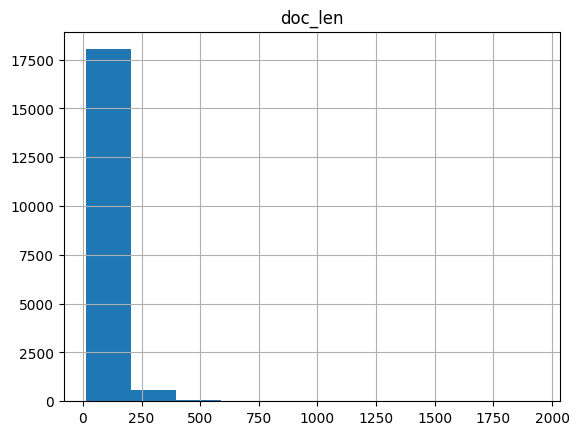

In [ ]:
data.hist()

In [ ]:
len(X_train)

18697

In [ ]:
len(X_test)

2078

### 4. 모델 학습

In [ ]:
# 데이터셋 준비
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts  # 텍스트 데이터
        self.labels = labels  # 레이블 데이터
        self.tokenizer = tokenizer  # 토크나이저
        self.max_length = max_length  # 최대 길이

    def __len__(self):
        return len(self.texts)  # 데이터셋 크기 반환

    def __getitem__(self, idx):  # 배치 데이터 호출할 때 사용
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # 텍스트의 토큰 ID
            'attention_mask': encoding['attention_mask'].squeeze(0),  # 패딩 여부
            'labels': torch.tensor(label, dtype=torch.long)  # 레이블
        }

In [ ]:
# Hyperparameters
MAX_LENGTH = 250
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-5

In [ ]:
type(X_train)  # list

list

In [ ]:
type(y_train)  # list

list

In [ ]:
# 데이터 토큰화
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
train_dataset = CustomDataset(X_train, y_train, tokenizer, MAX_LENGTH)
test_dataset = CustomDataset(X_test, y_test, tokenizer, MAX_LENGTH)

# 데이터셋을 배치로 나누어 모델 학습에 사용할 수 있도록 준비
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
# 데이터셋의 레이블 값 확인
print("Unique labels in train set:", set(train_loader.dataset.labels))
print("Unique labels in test set:", set(test_loader.dataset.labels))

Unique labels in train set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40}
Unique labels in test set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 39}


In [ ]:
import torch
print(torch.cuda.is_available())  # True여야 함
print(torch.cuda.device_count())  # GPU 개수
print(torch.cuda.get_device_name(0))  # GPU 이름 출력

True
3
NVIDIA GeForce RTX 3080


In [ ]:
# 모델 준비
num_labels = max(train_loader.dataset.labels) + 1  # 41로 설정
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)  # 가중치 감쇠
criterion = torch.nn.CrossEntropyLoss()

/home/jinmin/miniconda3/envs/food/lib/python3.8/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from tqdm import tqdm

def train_model(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct = 0, 0
    total_samples = 0

    # tqdm으로 진행률 표시
    loop = tqdm(data_loader, desc="Training", leave=False)  # leave=False: 학습이 끝나면 진행률 표시줄을 지움.

    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        # 모델에 입력 데이터를 전달하여 예측값(logits)과 손실(loss)을 계산
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass
        loss.backward()  # 손실의 그래디언트를 계산 (역전파)
        optimizer.step()  # 계산된 그래디언트를 기반으로 모델 파라미터를 업데이트

        # Metrics
        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == labels).sum().item()  # 정답 예측한 샘플의 수
        total_samples += labels.size(0)  # 처리된 총 샘플의 수

        # Update tqdm description
        loop.set_postfix(loss=loss.item())

    accuracy = total_correct / total_samples  # 에포크 동안 모든 배치의 평균 손실 값
    avg_loss = total_loss / len(data_loader)  # 정확히 예측한 샘플 수를 전체 샘플 수로 나눈 값
    return avg_loss, accuracy

In [ ]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()  # 드롭아웃 및 배치 정규화가 비활성화
    total_loss, total_correct = 0, 0
    total_samples = 0
    all_predictions, all_labels = [], []

    # tqdm으로 진행률 표시
    loop = tqdm(data_loader, desc="Evaluating", leave=False)

    with torch.no_grad():  # 평가 중에는 그래디언트 계산 비활성화
        for batch in loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            # Metrics
            total_loss += loss.item()
            total_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_samples += labels.size(0)

            # 이후에 정밀도, 재현율, F1-score 같은 추가 지표를 계산할 때 활용
            all_predictions.extend(logits.argmax(dim=1).cpu().numpy())  # 모든 배치의 예측값을 저장
            all_labels.extend(labels.cpu().numpy())  # 모든 배치의 실제 레이블을 저장

            # Update tqdm description
            loop.set_postfix(loss=loss.item())

    accuracy = total_correct / total_samples
    avg_loss = total_loss / len(data_loader)
    return avg_loss, accuracy, all_predictions, all_labels

In [ ]:
# 학습 루프
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_loss, train_accuracy = train_model(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy, _, _ = evaluate_model(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/10


Training:   0%|          | 0/1169 [00:00<?, ?it/s]

Train Loss: 2.1385, Train Accuracy: 0.3970
Val Loss: 1.7574, Val Accuracy: 0.5043
Epoch 2/10


Train Loss: 1.4354, Train Accuracy: 0.5942
Val Loss: 1.2813, Val Accuracy: 0.6526
Epoch 3/10


Train Loss: 0.9178, Train Accuracy: 0.7603
Val Loss: 0.9614, Val Accuracy: 0.7565
Epoch 4/10


Train Loss: 0.6917, Train Accuracy: 0.8195
Val Loss: 0.8013, Val Accuracy: 0.7945
Epoch 5/10


Train Loss: 0.5365, Train Accuracy: 0.8582
Val Loss: 0.6977, Val Accuracy: 0.8239
Epoch 6/10


Train Loss: 0.4327, Train Accuracy: 0.8846
Val Loss: 0.6928, Val Accuracy: 0.8349
Epoch 7/10


Train Loss: 0.3581, Train Accuracy: 0.9025
Val Loss: 0.6847, Val Accuracy: 0.8388
Epoch 8/10


Train Loss: 0.3010, Train Accuracy: 0.9180
Val Loss: 0.6437, Val Accuracy: 0.8489
Epoch 9/10


Train Loss: 0.2548, Train Accuracy: 0.9288
Val Loss: 0.6945, Val Accuracy: 0.8364
Epoch 10/10


Train Loss: 0.2196, Train Accuracy: 0.9374
Val Loss: 0.6992, Val Accuracy: 0.8489


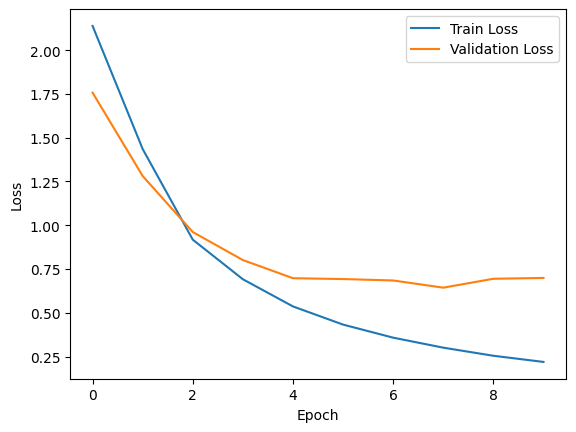

In [ ]:
# 손실 시각화
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

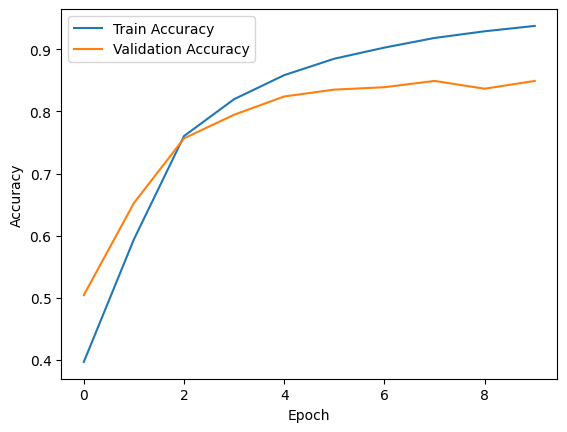

In [ ]:
# 정확도 시각화
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# 테스트 데이터 평가
_, _, y_preds, y_labels = evaluate_model(model, test_loader, criterion, device)
print(classification_report(y_labels, y_preds))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       447
           1       0.62      0.68      0.65       108
           2       0.92      0.96      0.94       124
           3       0.83      0.89      0.86        75
           4       0.84      0.63      0.72       180
           5       0.78      0.62      0.69        50
           6       0.79      0.75      0.77        67
           7       0.91      0.97      0.94       212
           8       0.95      0.97      0.96        77
           9       0.95      0.83      0.89        42
          10       0.83      0.90      0.86       147
          11       0.00      0.00      0.00         8
          12       0.42      0.84      0.56        37
          13       0.96      0.97      0.96       135
          14       0.85      0.66      0.74        35
          15       0.71      0.77      0.74        13
          16       0.88      0.96      0.91        89
          17       0.50    

/home/jinmin/miniconda3/envs/food/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jinmin/miniconda3/envs/food/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jinmin/miniconda3/envs/food/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [ ]:
# 메모리 사용량 최적화 방안
# - 배치 크기 줄이기
# - max_length 줄이기